In [1]:
import time
start_time=time.time()

Power Spectrum: Obtaining the 1DPSD.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

import scipy.fftpack
from astropy.io import fits
import astropy.units as u
#Methods
from scipy import ndimage
from radial_data import radial_data
import radialProfile
from turbustat.statistics import PowerSpectrum 

Data

In [3]:
data=pd.read_table('datos.txt')
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


Data rearrange / 2D Map

In [4]:
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')

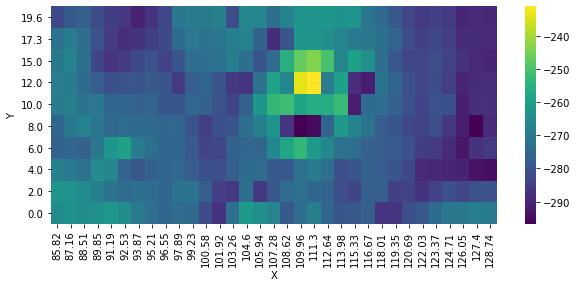

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()

Recipe for the 1DPSD obtained from an image:

I) FFT on the two-dimenional data (Image) \
II) Shifting Frequency (Wavenumbers) components: Nyquist freq. at the corners.\
III) Calculate the radial average of the transformed shifted image. The startig point is the center of the image and the average is made around 'rings' having a particular distance from this point. \
IV) Plotting these averages vs wavebumbers.\

In the case of I and II) the procedure is straightforward thanks to scipy FFT library. 

For option III) we evaluate and compare different procedures: \

1) Using the ndimage sum and avergae option(https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59). \
2) Doing by "hand" the ndimage stuff: Out Of the Box (OOB) Method. \
3) Using the codes radial_data and radialProfile (https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/). \
4) using the Turbustat package (https://turbustat.readthedocs.io/en/latest/#). 

For option IV) the wavenumber calculation is implemented considering k=2*pi/l where l is the distance of the  averaged ring from the center.

NOTES: Methods 1,2 and 3 use as input the transformed shifted image. Method 4 use the original image.

2D Fourier Transform 

In [6]:
dataFT=data_2

In [7]:
FT2a=scipy.fftpack.fft2(dataFT)
power_s0=np.abs(FT2a)

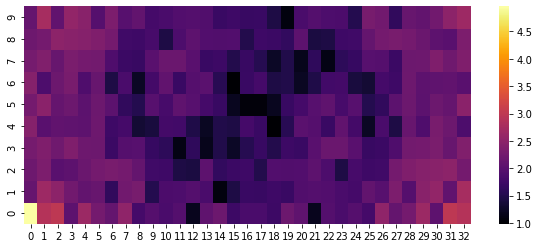

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()

Shifted components 

In [9]:
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)**2

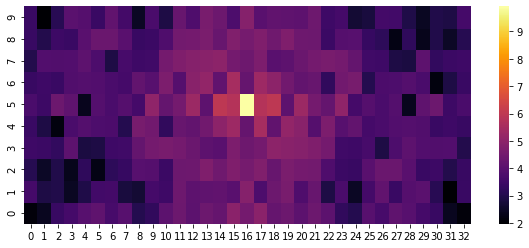

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()

Distance to components. \
Source: https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59

Create an array of "rings" parting from the center of the image. 

In [11]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

In [12]:
# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

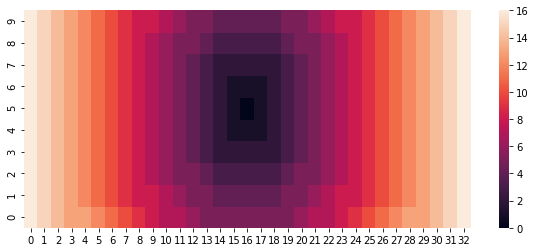

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rdf)
plt.gca().invert_yaxis()

Radial Average Methods

Same as above for ndimage.sum and ndimage.mean but doing all the procedure by "hand" to obtain the error. The same array of rings is used as above.

In [14]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

OBB mean

Doing now the average...

In [15]:
for i in range(wc):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T

In [16]:
norm=psd1D_2mx

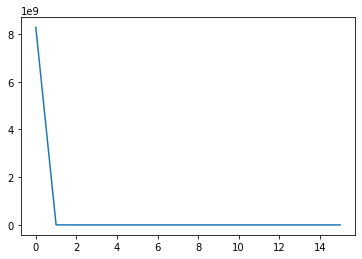

In [17]:
plt.plot(psd1D_2mx[1])

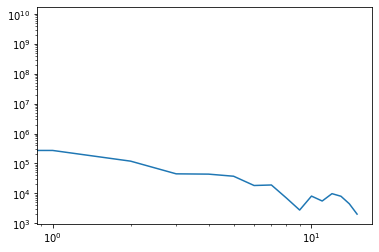

In [18]:
plt.loglog(psd1D_2mx[1])

Interpolate

In [19]:
pickle_in = open("604IHAH.pkl","rb")
data2 = pickle.load(pickle_in)

In [20]:
datavr2=data2[0].pivot(index='Y', columns='X', values='RV')

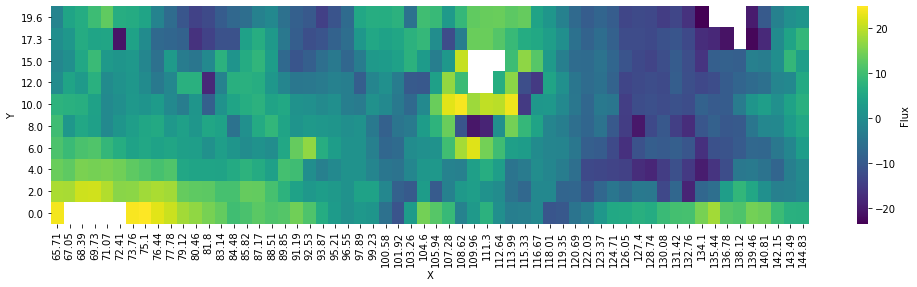

In [21]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(datavr2, cmap="viridis",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()

In [22]:
datavr2=datavr2.interpolate(method='linear',limit_direction ='both')

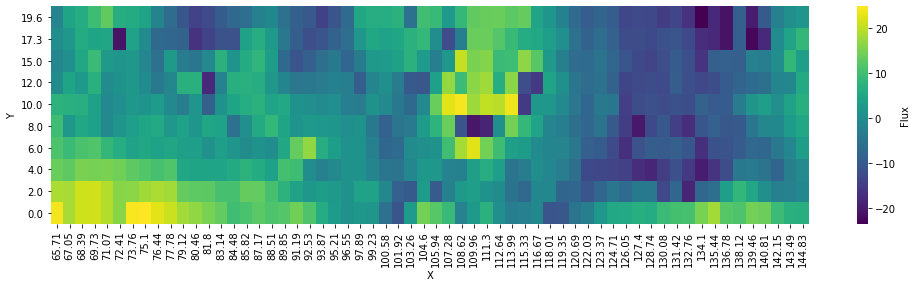

In [23]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(datavr2, cmap="viridis",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()

In [24]:
dataFT=datavr2

In [25]:
FT2a=scipy.fftpack.fft2(dataFT)
power_s0=np.abs(FT2a)

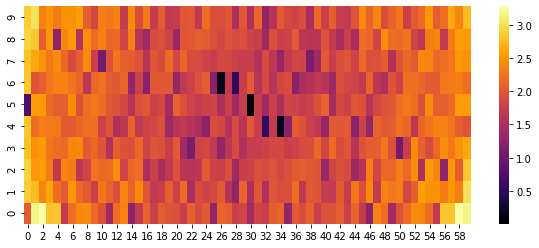

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()

In [27]:
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)**2

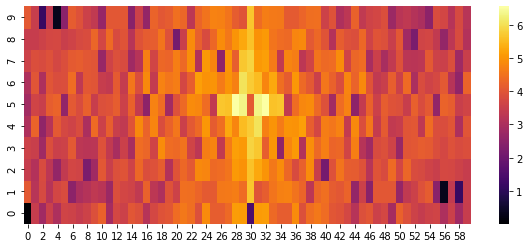

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()

In [29]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

In [30]:
# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

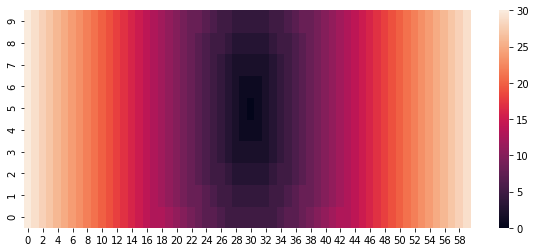

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rdf)
plt.gca().invert_yaxis()

In [32]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [33]:
for i in range(wc):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T


In [34]:
intp=psd1D_2mx

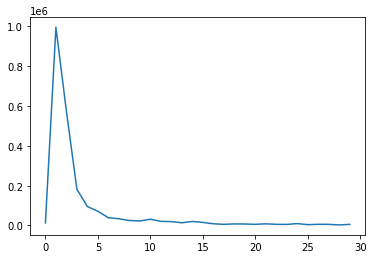

In [35]:
plt.plot(psd1D_2mx[1])

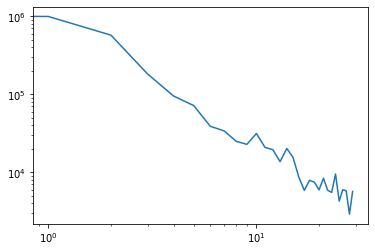

In [36]:
plt.loglog(psd1D_2mx[1])

Fill

In [37]:
pickle_in = open("604IHCH.pkl","rb")
data3 = pickle.load(pickle_in)

In [38]:
datavr3=data3[0].pivot(index='Y', columns='X', values='RV')

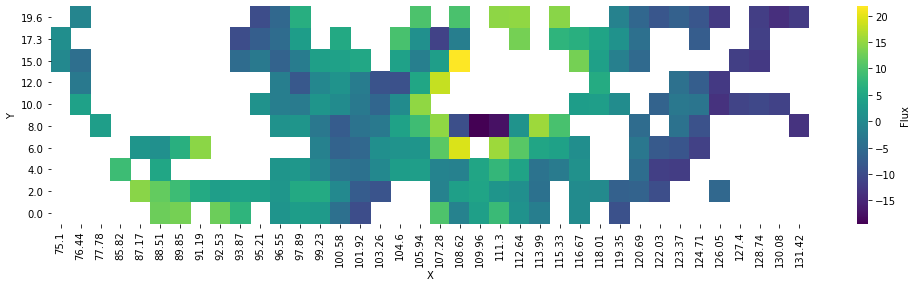

In [39]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(datavr3, cmap="viridis",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()

In [40]:
datavr1x=datavr3.fillna(value=-100)
datavr2x=datavr3.fillna(value=0)
datavr3x=datavr3.fillna(value=100)

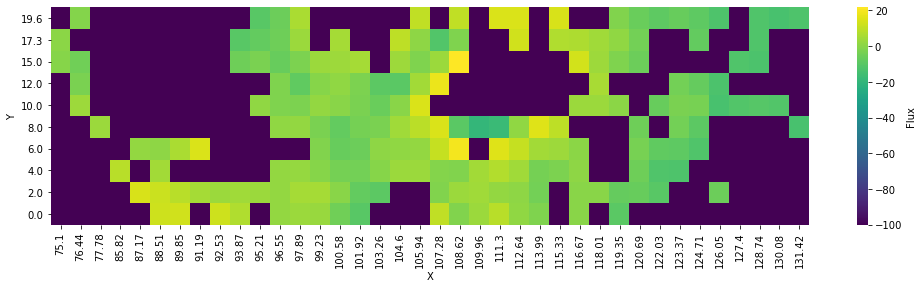

In [41]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(datavr1x, cmap="viridis",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()

In [42]:
dataFT=datavr1x

In [43]:
FT2a=scipy.fftpack.fft2(dataFT)
power_s0=np.abs(FT2a)

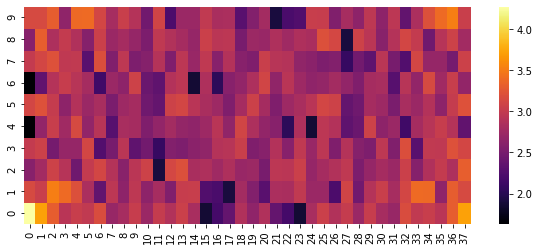

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()

In [45]:
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)**2

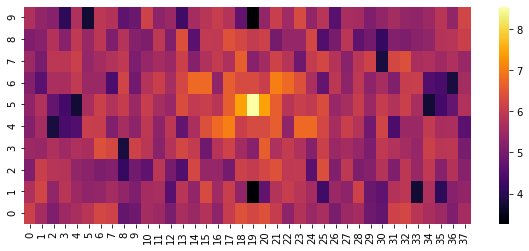

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()

In [47]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

In [48]:
# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

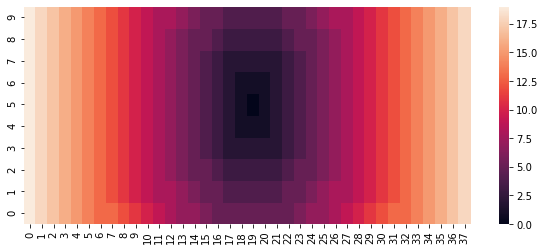

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rdf)
plt.gca().invert_yaxis()

In [50]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [51]:
for i in range(wc):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T


In [52]:
fl1=psd1D_2mx

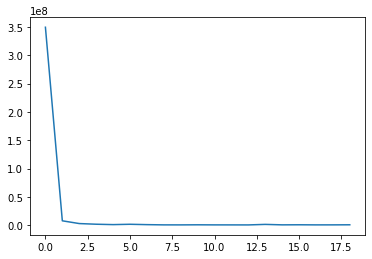

In [53]:
plt.plot(psd1D_2mx[1])

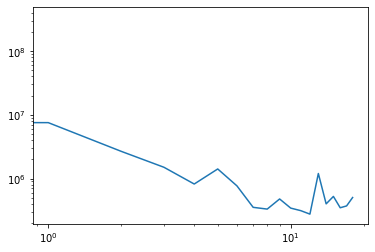

In [54]:
plt.loglog(psd1D_2mx[1])

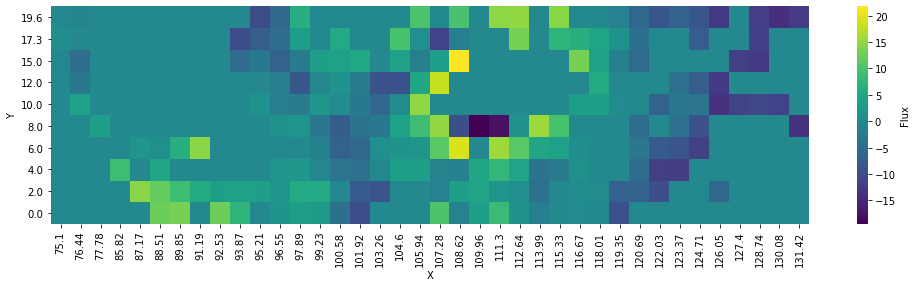

In [55]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(datavr2x, cmap="viridis",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()

In [56]:
dataFT=datavr2x

In [57]:
FT2a=scipy.fftpack.fft2(dataFT)
power_s0=np.abs(FT2a)

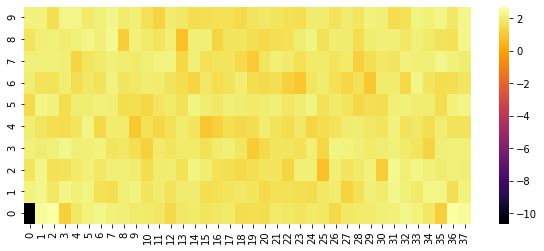

In [58]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()

In [59]:
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)**2

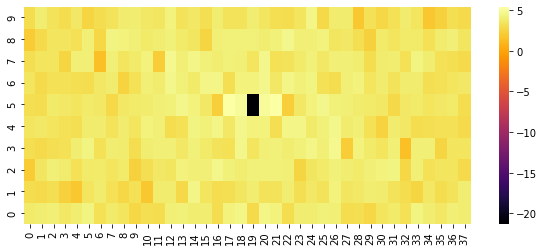

In [60]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()

In [61]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

In [62]:
# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

In [63]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [64]:
for i in range(wc):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T


In [65]:
fl2=psd1D_2mx

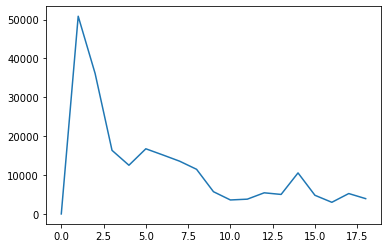

In [66]:
plt.plot(psd1D_2mx[1])

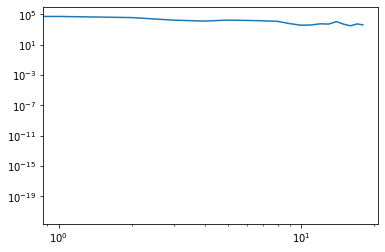

In [67]:
plt.loglog(psd1D_2mx[1])

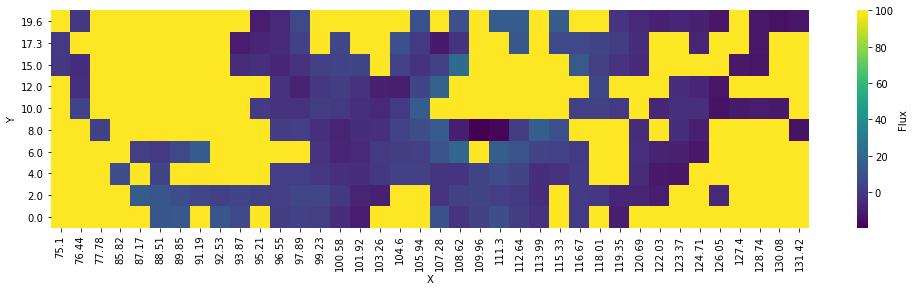

In [68]:
fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(datavr3x, cmap="viridis",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.gca().invert_yaxis()

In [69]:
dataFT=datavr3x

In [70]:
FT2a=scipy.fftpack.fft2(dataFT)
power_s0=np.abs(FT2a)

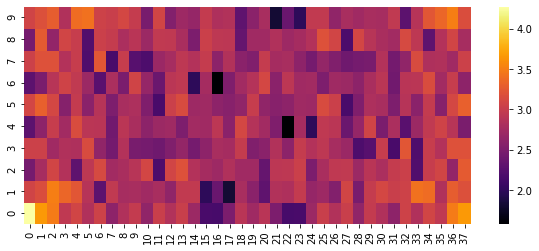

In [71]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s0), cmap="inferno")
plt.gca().invert_yaxis()

In [72]:
FT2 = scipy.fftpack.fftshift(FT2a)
power_s = np.abs(FT2)**2

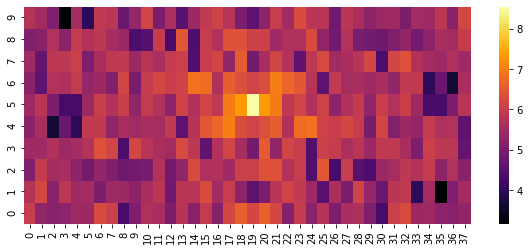

In [73]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(np.log10(power_s), cmap="inferno")
plt.gca().invert_yaxis()

In [74]:
h  = power_s.shape[0]
w  = power_s.shape[1]
wc = w//2
hc = h//2

In [75]:
# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)
rdf=pd.DataFrame(r)

In [76]:
psdf=pd.DataFrame(power_s)
data_ps=dict()

In [77]:
for i in range(wc):
    m=(rdf==i)
    psm=psdf[m]
    s=(psm.mean()).mean()
    err=(psm.std()/np.sqrt(len(psm))).mean()
    data_ps[i]=[i,s,err]
    
psd1D_2mx=pd.DataFrame(data_ps).T

In [78]:
fl3=psd1D_2mx

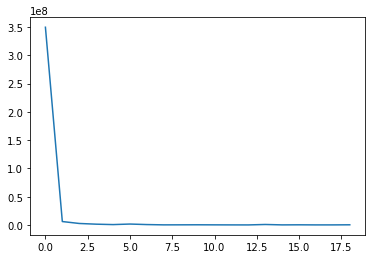

In [79]:
plt.plot(psd1D_2mx[1])

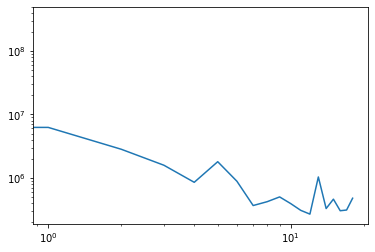

In [80]:
plt.loglog(psd1D_2mx[1])

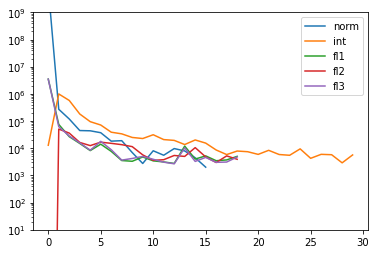

In [84]:
plt.semilogy(norm[1],label='norm')
plt.semilogy(intp[1],label='int')
plt.semilogy(fl1[1]/100,label='fl1')
plt.semilogy(fl2[1],label='fl2')
plt.semilogy(fl3[1]/100,label='fl3')
plt.ylim(10*1, 10**9) 
plt.legend()

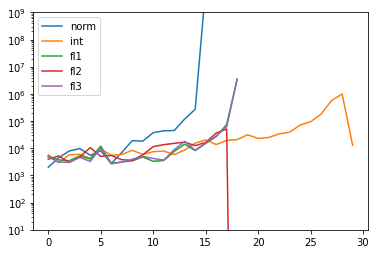

In [91]:
array=np.array(norm[1])[::-1] 

plt.semilogy(np.array(norm[1])[::-1],label='norm')
plt.semilogy(np.array(intp[1])[::-1],label='int')
plt.semilogy(np.array(fl1[1])[::-1]/100,label='fl1')
plt.semilogy(np.array(fl2[1])[::-1],label='fl2')
plt.semilogy(np.array(fl3[1])[::-1]/100,label='fl3')
plt.ylim(10*1, 10**9) 
plt.legend()


In [83]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 19.474404096603394 seconds ---
